Locate phoneme positions which best separate candidate speech representations.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [32]:
from collections import Counter, defaultdict
import itertools
from pathlib import Path
import pickle
from typing import Any

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold
import torch
import transformers
from tqdm.auto import tqdm

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings

In [3]:
model_checkpoints = {
    "word_prefix": "out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600",
    "phoneme": "out/ce_model_phoneme_6_8/checkpoint-800/",
}

equiv_dataset_path = "data/timit_equiv_phoneme_1.pkl"
traj_path = "out/state_space_specs/all_phonemes_by_position.pkl"

In [6]:
models = {
    k: ContrastiveEmbeddingModel.from_pretrained(v)
    for k, v in model_checkpoints.items()
}

In [18]:
model_names = list(models.keys())

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset = pickle.load(f)

In [13]:
with open(traj_path, "rb") as f:
    traj_spec: StateSpaceAnalysisSpec = pickle.load(f)

In [14]:
assert traj_spec.is_compatible_with(equiv_dataset)

In [12]:
model_representations = {
    k: compute_embeddings(v, equiv_dataset, device="cpu").numpy()
    for k, v in tqdm(list(models.items()))
}

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4740 [00:00<?, ?it/s]

  0%|          | 0/4740 [00:00<?, ?it/s]

## PWCCA definition

https://github.com/1Konny/Projection_Weighted_CCA/blob/master/cca.py

In [121]:
# copy&paste from: https://github.com/google/svcca/blob/master/cca_core.py
def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
        array: A numpy 2d array, can be complex valued that is a positive
            definite symmetric (or hermitian) matrix

    Returns:
        sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


# copy&paste from: https://github.com/google/svcca/blob/master/cca_core.py
def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, threshold=1e-6):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
        sigma_xx: 2d numpy array, variance matrix for x
        sigma_xy: 2d numpy array, crossvariance matrix for x,y
        sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
            (conjugate) transpose of sigma_xy
        sigma_yy: 2d numpy array, variance matrix for y
        threshold: cutoff value for norm below which directions are thrown
            away

    Returns:
            sigma_xx_crop: 2d array with low x norm directions removed
            sigma_xy_crop: 2d array with low x and y norm directions removed
            sigma_yx_crop: 2d array with low x and y norm directiosn removed
            sigma_yy_crop: 2d array with low y norm directions removed
            x_idxs: indexes of sigma_xx that were removed
            y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = (x_diag >= threshold)
    y_idxs = (y_diag >= threshold)

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def gs_orthonormalize(array):
    """Gram-Schmidt orthonormalization."""
    q, _ = np.linalg.qr(array)
    if q.shape[1] < array.shape[1]:
        zero_pad = np.zeros(shape=(q.shape[0], array.shape[1]-q.shape[1]))
        q = np.concatenate([q, zero_pad], 1)
    return q


# modified from and built on the codes in https://github.com/google/svcca/blob/master/cca_core.py
def solve_cca(x, y):
    """Calculate CCA correlations, position vectors, images, and Mean|Projection Weighted similarity.
    
    The terms, 'correlation', 'position vector', 'image' are detailed in [1].
    [1] A Tutorial on Canonical Correlation Methods, Uurtio et al
    
    Args:
        x: A representation of shape (num_neurons, num_datapoints)
        y: A representation of shape (num_neurons, num_datapoints)
    """
    assert x.ndim == y.ndim == 2, 'both x and y should be 2D array, [num_neurons, num_datapoints]'
    assert x.shape[1] == y.shape[1], 'the number of datapoints between x and y do not match'
    assert x.shape[0] <= x.shape[1], 'num_datapoints should be greater than or equal to num_neurons. please check x.shape'
    assert y.shape[0] <= y.shape[1], 'num_datapoints should be greater than or equal to num_neurons. please check y.shape'
    epsilon = 1e-6
    
    numx = x.shape[0]
    numy = y.shape[0]

    sigma = np.cov(x, y)
    sigmaxx = sigma[:numx, :numx]
    sigmaxy = sigma[:numx, numx:]
    sigmayx = sigma[numx:, :numx]
    sigmayy = sigma[numx:, numx:]

    # normalize covariance matrices for stability
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax*ymax)
    sigmayx /= np.sqrt(ymax*xmax)
    
    # remove negligibly small covariances
    sigmaxx, sigmaxy, sigmayx, sigmayy, x_idxs, y_idxs = remove_small(sigmaxx, sigmaxy, sigmayx, sigmayy)
    x = x[x_idxs]
    y = y[y_idxs]

    numx = sigmaxx.shape[0]
    numy = sigmayy.shape[0]
    if numx == 0 or numy == 0:
        raise NotImplementedError('check here.')

    sigmaxx += epsilon*np.eye(numx)
    sigmayy += epsilon*np.eye(numy)
    inv_sigmaxx = np.linalg.pinv(sigmaxx)
    inv_sigmayy = np.linalg.pinv(sigmayy)
    invsqrt_sigmaxx = positivedef_matrix_sqrt(inv_sigmaxx)
    invsqrt_sigmayy = positivedef_matrix_sqrt(inv_sigmayy)

    arrx = invsqrt_sigmaxx.dot(sigmaxy).dot(inv_sigmayy.dot(sigmayx.dot(invsqrt_sigmaxx)))
    arry = invsqrt_sigmayy.dot(sigmayx).dot(inv_sigmaxx.dot(sigmaxy.dot(invsqrt_sigmayy)))
    arrx += epsilon*np.eye(arrx.shape[0])
    arry += epsilon*np.eye(arry.shape[0])

    ux, sx, vhx = np.linalg.svd(arrx)
    uy, sy, vhy = np.linalg.svd(arry)

    cca_corr_x = np.sqrt(np.abs(sx)) # each value represents k-th order canonical correlation coefficient of x
    cca_corr_x = np.where(cca_corr_x>1, 1, cca_corr_x)
    cca_corr_x = np.where(cca_corr_x<epsilon, 0, cca_corr_x)
    
    cca_corr_y = np.sqrt(np.abs(sy)) 
    cca_corr_y = np.where(cca_corr_y>1, 1, cca_corr_y)
    cca_corr_y = np.where(cca_corr_y<epsilon, 0, cca_corr_y)
    
    # check
    cca_pos_x = vhx.dot(invsqrt_sigmaxx) # each row represents k-th order canonical correlation position vector of x
    cca_pos_y = vhy.dot(invsqrt_sigmayy)
    
    # check
    cca_image_x = cca_pos_x.dot(x) # each row represents k-th order canonical correlation image of x
    cca_image_y = cca_pos_y.dot(y)

    min_numxy = min(numx, numy)
    truncated_corr_x = cca_corr_x[:min_numxy]
    truncated_corr_y = cca_corr_y[:min_numxy]
    equally_weighted_cca_sim_x = truncated_corr_x.mean()
    equally_weighted_cca_sim_y = truncated_corr_y.mean()
    
    truncated_cca_image_x = cca_image_x[:min_numxy]
    truncated_cca_image_y = cca_image_y[:min_numxy]

    # check
    orthonorm_cca_image_x = gs_orthonormalize(truncated_cca_image_x)
    orthonorm_cca_image_y = gs_orthonormalize(truncated_cca_image_y)

    projection_weights_x = np.abs(orthonorm_cca_image_x.dot(x.T)).sum(1)
    projection_weights_x /= projection_weights_x.sum()
    projection_weighted_cca_sim_x = (projection_weights_x*truncated_corr_x).sum() # dist = 1 - sim

    projection_weights_y = np.abs(orthonorm_cca_image_y.dot(y.T)).sum(1)
    projection_weights_y /= projection_weights_y.sum()
    projection_weighted_cca_sim_y = (projection_weights_y*truncated_corr_y).sum() # dist = 1 - sim
    
    output_dicts = {}
    output_dicts['cca_corr_x'] = cca_corr_x
    output_dicts['cca_corr_y'] = cca_corr_y
    output_dicts['cca_pos_x'] = cca_pos_x
    output_dicts['cca_pos_y'] = cca_pos_y
    output_dicts['cca_image_x'] = cca_image_x
    output_dicts['cca_image_y'] = cca_image_y
    output_dicts['ewcca_sim_x'] = equally_weighted_cca_sim_x
    output_dicts['ewcca_sim_y'] = equally_weighted_cca_sim_y
    output_dicts['pwcca_sim_x'] = projection_weighted_cca_sim_x
    output_dicts['pwcca_sim_y'] = projection_weighted_cca_sim_y

    return output_dicts

In [149]:
cv_folds = 2
cca_scores = np.zeros((len(traj_spec.labels), len(model_names), len(model_names), cv_folds))
cca_scores.fill(np.nan)

In [150]:
for i, phoneme_position in enumerate(tqdm(traj_spec.labels)):
    print(i)
    for model_j, model_k in itertools.product(list(range(len(model_names))), repeat=2):
        if model_j >= model_k:
            continue
        spans = traj_spec.target_frame_spans[i]

        # Only extract frames from span which have a Q label
        frames = [[frame for frame in range(start_frame, end_frame + 1) if equiv_dataset.Q[frame] != -1]
                  for start_frame, end_frame in spans]
        
        frames = list(itertools.chain.from_iterable(frames))

        rep_j = model_representations[model_names[model_j]][frames]
        rep_k = model_representations[model_names[model_k]][frames]

        # # TODO consider other agg fns
        # rep_j = np.stack([model_representations[model_names[model_j]][start_frame:end_frame + 1].mean(0)
        #                   for start_frame, end_frame in spans])
        # rep_k = np.stack([model_representations[model_names[model_k]][start_frame:end_frame + 1].mean(0)
        #                   for start_frame, end_frame in spans])

        assert rep_k.shape[0] == rep_j.shape[0]

        if rep_j.shape[0] < cv_folds * 2 or rep_j.shape[0] < rep_j.shape[1] or rep_k.shape[0] < rep_k.shape[1]:
            continue

        cv = KFold(n_splits=cv_folds, shuffle=True)
        for fold, (train_idx, test_idx) in enumerate(cv.split(rep_j)):
            try:
                result = solve_cca(rep_j[train_idx].T, rep_k[train_idx].T)
            except AssertionError:
                pass # too little data
            else:
                cca_scores[i, model_j, model_k, fold] = result['pwcca_sim_x']
            # cca = CCA(n_components=min(rep_j.shape[1], rep_k.shape[1]))
            # cca.fit(rep_j[train_idx], rep_k[train_idx])

            # test_j_trans, test_k_trans = cca.transform(rep_j[test_idx], rep_k[test_idx])
            # print(np.corrcoef(test_j_trans, test_k_trans).shape)
            # cca_scores[i, model_j, model_k, fold] = np.corrcoef(test_j_trans, test_k_trans)[0, 1]

  0%|          | 0/14 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [151]:
cca_scores_df = []
for i, model_i, model_j, fold in np.ndindex(*cca_scores.shape):
    cca_scores_df.append({
        "position": traj_spec.labels[i],
        "fold": fold,
        "model_i": model_names[model_i],
        "model_j": model_names[model_j],
        "cca_score": cca_scores[i, model_i, model_j, fold],
    })
cca_scores_df = pd.DataFrame(cca_scores_df).dropna()

In [153]:
cca_scores_df["comparison"] = cca_scores_df["model_i"] + " vs " + cca_scores_df["model_j"]

<Axes: xlabel='position', ylabel='cca_score'>

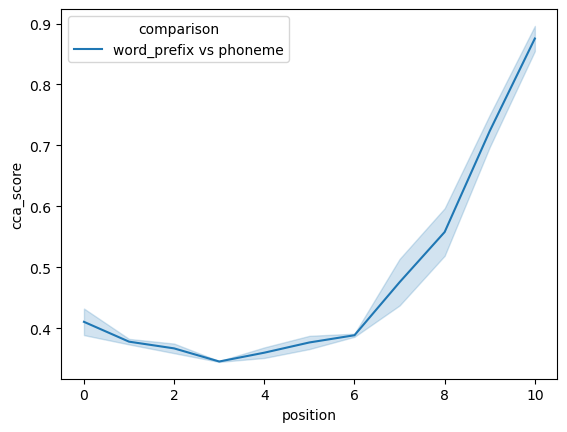

In [154]:
sns.lineplot(data=cca_scores_df, x="position", y="cca_score", hue="comparison")